
# Sentiment Classification of Movie Reviews
Sentiment classification is often one of the first NLP projects for students. There is a lot of suitable data available online and its implementation is a lot easier than other typical NLP tasks, such as machine translation or language generation. Nevertheless it bears practical significance (e.g. analysis of customer feedback) and is still a challange, even with modern approaches.

The goal of this exercise is to compare two differen simple approaches to sentiment classification of movie reviews: A sentiment lexicon and a discriminative classifier.

## Necessary Packages
The code for this task makes use of the following packages: scikit-learn, NLTK, pandas, glob, typing, matplotlib and wordcloud

In [1]:
%matplotlib inline
import pandas as pd
from glob import glob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from typing import List

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from joblib import dump

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# get nltk data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/raffael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raffael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/raffael/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Dataset

The movie review dataset used in this task is the polarity dataset v2 from Bo Pang and Lillian Lee: http://www.cs.cornell.edu/people/pabo/movie-review-data/

The dataset *polarity dataset v2.0* has to be extracted in the same folder as this notebook.

The movie reviews are already divided into positive and negative reviews. They are loaded and stored in a dataframe, where each review is assigned a 'pos' or 'neg' label.

In [2]:
# relative path to the sentiment files
path_sent = 'review_polarity/txt_sentoken'

def load_reviews(path: str, label: str) -> pd.DataFrame:
    """ Load all review files with the same label into a DataFrame.

    Args:
        path: Relative path to where the sentiment files are stored.
        label: Name of the folder where all sentiment files with the same label are stored.

    Returns:
        DataFrame with all labelled sentiment files of one label.

    """
    # dataframe to store all reviews
    reviews_df = pd.DataFrame(columns=['file_name', 'text', 'label'])

    # get reviews
    filenames = glob(f'{path}/{label}/*.txt')
    assert len(filenames) != 0, f"No {label} reviews available."

    for file_name in filenames:
        file = open(file_name)
        text = file.read()
        reviews_df = reviews_df.append({
            'file_name': file_name, 'text': text, 'label': label},
            ignore_index=True)
        file.close()
    
    return reviews_df


# load all positive and all negative reviews into a dataframe
reviews_df = pd.concat([load_reviews(path_sent, 'neg'), load_reviews(path_sent, 'pos')]).reset_index()

We have a look at a random review from the dataset and its label:

In [3]:
print(reviews_df.loc[8,'text'])

the best thing about , " lake placid " is that it's only 80 minutes long and when it's over you're glad that you didn't waste more than an hour and a half of your time . 
it's nothing more than a bad rip-off of , " jaws " ( and i think that's being kind . ) 
it was written by david e . kelly ( " ally mcbeal " ) as a horror-comedy but fails at both , miserably . 
i was never scared and i think that i only laughed once . 
the crocodile even fails in comparison to the snake in , " anaconda . " 
the plot begins when a man is eaten in half by the giant crocodile in black lake in maine . 
that brings the local sheriff ( brendan gleeson ) and a fish-and-game warden ( bill pulman ) to investigate . 
also , a paleontologist ( bridget fonda ) from new york is sent to look at a tooth and an eccentric millionaire/crocodile lover ( oliver platt ) flies in because he wants to swim beside the beast . 
soon there is tension between everybody because half the people want to kill the croc and the other 

In [4]:
print(reviews_df.loc[8,'label'])

neg


A quick overview of the dataset:

'Info:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      2000 non-null   int64 
 1   file_name  2000 non-null   object
 2   text       2000 non-null   object
 3   label      2000 non-null   object
dtypes: int64(1), object(3)
memory usage: 62.6+ KB


None

'Label value counts:'

neg    1000
pos    1000
Name: label, dtype: int64

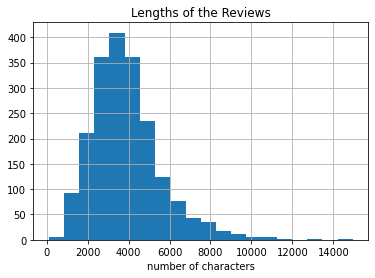

In [5]:
# Some information about the dataframe
display("Info:")
display(reviews_df.info())

# Check if there are more positive or negative reviews
display("Label value counts:")
display(reviews_df['label'].value_counts())

# Get the lengths of the reviews
fig, ax = plt.subplots()
reviews_df['text'].apply(len).hist(axes=ax, bins=20)
ax.set(xlabel='number of characters', title='Lengths of the Reviews')
plt.show()

The dataset consists of 2000 movie reviews, has no missing values and is balanced. Most reviews are approximately 3'500 characters long, with an overall variety of lengths, shown in the histogram above.

## Test set
400 reviews are randomly selected and hold out as a test set to evaluate the performance of the created models.

In [6]:
train_reviews, test_reviews, train_labels, test_labels = train_test_split(
    reviews_df['text'].to_numpy(),
    reviews_df['label'].to_numpy(),
    test_size=400,
    random_state=42
    )

## Preprocessing
The reviews are stored as strings. Before features can be extracted, the following preprocessing steps are performed:
* tokenization
* removal of non-alphabetical tokens
* removal of common stopwords
* lemmatization

In [7]:
def preprocess_review(string: str) -> List[str]:
    """Preprocess one movie review by performing tokenization, removal of
    non-alphabetical tokens and stopwords, lemmatization.
    
    Args:
        string: One movie review as a single string
    
    Returns:
        A list of preprocessed tokens.
    
    """
    # tokenize input
    tokens = word_tokenize(string.lower())

    # remove non-alphabetical tokens
    tokens_alpha = [w for w in tokens if w.isalpha()]

    # remove stopwords
    tokens_no_stops = [w for w in tokens_alpha
                       if w not in stopwords.words('english')]

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens_lemma = [lemmatizer.lemmatize(w) for w in tokens_no_stops]

    return tokens_lemma


# preprocess train and test reviews and store them in separate lists
train_reviews_pre = [preprocess_review(review) for review in train_reviews]
test_reviews_pre = [preprocess_review(review) for review in test_reviews]

# convert the label-arrays to lists
train_labels = train_labels.tolist()
test_labels = test_labels.tolist()

A fun way to visualize the tokens is with a word cloud. First we have a look only at the tokens from the positive labelled reviews:

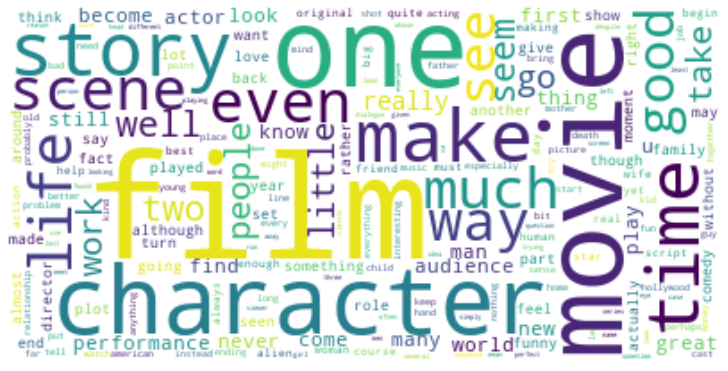

In [8]:
all_reviews_token = pd.DataFrame({'tokens':(train_reviews_pre + test_reviews_pre),
                                 'label': (train_labels + test_labels)})

# create and display a wordcloud of all preprocessed tokens
cloud = WordCloud(background_color='white').generate(
    ' '.join([' '.join(el) for el in all_reviews_token[all_reviews_token['label'] == 'pos']['tokens']])
)
plt.figure(figsize=[2*6.4, 2*4.8])
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

And the tokens from the negative labelled reviews:

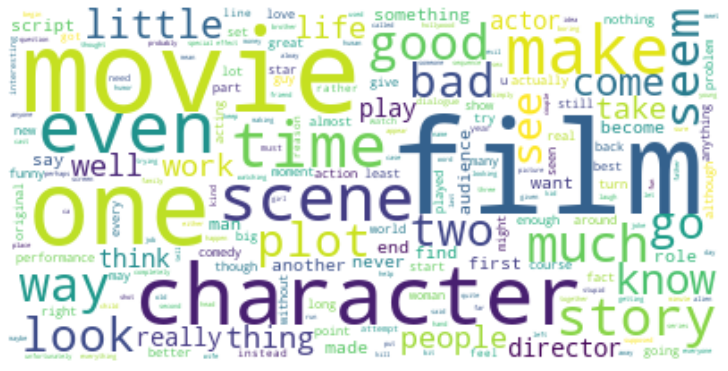

In [9]:
# create and display a wordcloud of all preprocessed tokens
cloud = WordCloud(background_color='white').generate(
    ' '.join([' '.join(el) for el in all_reviews_token[all_reviews_token['label'] == 'neg']['tokens']])
)
plt.figure(figsize=[2*6.4, 2*4.8])
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Lexicon-based classifier

A simple approch to classify the sentiment of the preprocessed movie reviews ist to use a sentiment lexicon, which simply counts the positive and the neative words in each review. The sentiment lexicon of Bing Liu is used: https://www.kaggle.com/nltkdata/opinion-lexicon
It has to be stored in the same directory as the notebook.

### Load the Lexicons
The lexicons for positive and negative words are loaded seperately. The words are lemmatized in the same way the reviews are during preprocessing, to assure comparability.

In [10]:
def get_lex(path_lex: str) -> List[str]:
    """Loads a sentiment-lexicon into a list of strings.
    
    Args:
        path_lex: Relative path to the lexicon-file.
    
    Returns:
        A list, containing all the words of the specified lexicon.
    
    """
    # read lexicon and transform to list
    lex = pd.read_csv(
        path_lex,
        comment=';',
        header=None,
        encoding='latin-1'
        ).to_numpy().ravel().tolist()

    # lemmatize lexicon to assure comparability to preprocessed reviews
    lemmatizer = WordNetLemmatizer()
    lex_lemma = [lemmatizer.lemmatize(w) for w in lex]

    return lex_lemma


# get positive and negative sentiment lexicons
lex_pos = get_lex('opinion_lexicon/positive-words.txt')
lex_neg = get_lex('opinion_lexicon/negative-words.txt')

### Classification and Evaluation
The classification process is simply counting negative and positive words in each review. No training is needed. Therefore this process can directly be performed on the test set and be evaluated on the ground truth.

As evaluation metric accuracy $\left( \frac{TP + TN}{TP+TN+FP+FN} \right)$ and the F<sub>1</sub>-score $\left( \frac{2 TP}{2 TP + FP + FN} \right)$ are used.

In [11]:
def classifiy_lemma(lemma: List[str], lex_pos: List[str], lex_neg: List[str]) -> str:
    """Classification of the sentiment of one movie review in the form of a list 
    of preprocessed tokens by counting positive and negative words.
    
    Args:
        lemma: One movie review as a list of preprocessed tokens.
        lex_pos: A List of positive words.
        lex_neg: A list of negative words.
    
    Returns:
        A label. 'pos' if more positive words have been counted, 'neg' otherwise.       
    
    """
    pos_count = sum([1 for w in lemma if w in lex_pos])
    neg_count = sum([1 for w in lemma if w in lex_neg])

    return 'pos' if pos_count >= neg_count else 'neg'


# predict sentiment of test set reviews with lexicons
test_labels_pred = [
    classifiy_lemma(review, lex_pos, lex_neg)
    for review in test_reviews_pre]

# convert predicted labels to 1 for positive and 0 for negative
label_dict = {'pos': 1, 'neg': 0}
test_labels_01 = [label_dict.get(i, i) for i in test_labels]
test_labels_pred_01 = [label_dict.get(i, i) for i in test_labels_pred]

# calculate accuary and F1 score on test set
display(f'Accuracy of lexicon based classification: \
    {accuracy_score(test_labels_01, test_labels_pred_01):.4f}')
display(f'F1-score of lexicon based classification: \
    {f1_score(test_labels_01, test_labels_pred_01):.4f}')

'Accuracy of lexicon based classification:     0.6800'

'F1-score of lexicon based classification:     0.6718'

## Discriminative Classifier
As second model a discriminative classifier is trained on the test set. The tokens are vectorized with their term frequency - inverse document frequency (tfidf). These are then used as features for a (regularized) logistic regression model. The performance is again evaluated on the held out test set.

In [12]:
# reviews are already tokenized, therefore a dummy function
# is passed to the vectorizer
def dummy_tokenizer(text: str) -> str:
    """ Dummy function, just returns the input argument."""
    return text


# Tfidf vectorization of the training and test reviews
vectorizer = TfidfVectorizer(
    lowercase=False,
    tokenizer=dummy_tokenizer,
    token_pattern=None
    )
vectorizer.fit(train_reviews_pre)
train_reviews_tfidf = vectorizer.transform(train_reviews_pre)
test_reviews_tfidf = vectorizer.transform(test_reviews_pre)

# convert labels to 1 for positive and 0 for negative
label_dict = {'pos': 1, 'neg': 0}
train_labels_01 = [label_dict.get(i, i) for i in train_labels]
test_labels_01 = [label_dict.get(i, i) for i in test_labels]

# use logistic regression to predict the labels of the test reviews
clf = LogisticRegression(C=10)
clf.fit(train_reviews_tfidf, train_labels_01)
test_labels_pred_01 = clf.predict(test_reviews_tfidf)

# calculate accuary and F1 score on test set
display('Accuracy of discriminative classification: {acc:.4f}'
      .format(acc=accuracy_score(test_labels_01, test_labels_pred_01)))
display('F1-score of discriminative classification: {f1:.4f}'
      .format(f1=f1_score(test_labels_01, test_labels_pred_01)))

'Accuracy of discriminative classification: 0.8475'

'F1-score of discriminative classification: 0.8530'

## Classify a self written review
The descriminative model actually doesn't perform too bad, considering its simplicity and the basic preprocessing. Here we take the first step in really using the model by passing a very short self written movie review string to it.

In [13]:
# my own review as a string
my_review = "This movie was a waste of time. I did not enjoy it!"

# preprocess and predict sentiment
my_review_pre = preprocess_review(my_review)
my_review_tfidf = vectorizer.transform([my_review_pre])
my_pred = clf.predict(my_review_tfidf)

# print prediction: 1 = positive, 0 = negative
print('pos' if my_pred[0] else 'neg')

neg


## Save model for deployment
A simple way to later use this model outside of this notebook is to save the trained classifier and vectorizer in separate files.

In [14]:
dump(vectorizer, 'api/vectorizer.joblib')
dump(clf, 'api/clf.joblib') 

['api/clf.joblib']

## Conclusion
The performance of the lexicon-based classifier is already good. An accuracy of 68% is clearly better than a coinflip, but not overwhelming. The trained logistic regression, with an accuracy of almost 85%, performes significantly better. This is due to the fact, that the discriminative approach is trained on a task-specific vocabulary and can also take into account whether certain words appear in combination with other words. The lexicon based approach on the other hand has a very general vocabulary and just counts word occurence.
Both methods don't take into account the context or the order of the words. The discriminative method could easily be expanded in this direction, by adding n-grams to the feature space.

The lexcion-based approach might also have its advantages. It is not dependent on (correctly) labeled training data, which might be expensive to get, and it might also generalize better to other similar tasks.

To better evaluate the classifiers, they could be evaluated on different test sets (cross-validation). Further could they be tested on a different task. E.g. they could be evaluated on car reviews (without retraining). The lexicon based approach should keep its performance, while the discriminative approach might decrease in accuracy.